# MNIST patches

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

## Pad images with 5x5 padding

In [3]:
kernel_size = 5
train_images_padded = np.pad(train_images, ((0, 0), (kernel_size - 1, kernel_size - 1), (kernel_size - 1, kernel_size - 1)))
train_images_padded.shape

(60000, 36, 36)

In [4]:
def out_size(img_size, kernel_size, stride, padding):
    return (img_size + 2 * padding - (kernel_size - 1) - 1) // stride + 1

def conv2d_patches(img, kernel_size=(5, 5), stride=1, padding=0):
    (img_width, img_height) = img.shape
    (kernel_width, kernel_height) = kernel_size
    out_width, out_height = out_size(img_width, kernel_width, stride, padding), out_size(img_height, kernel_height, stride, padding)

    padded_img = np.pad(img, ((padding, padding), (padding, padding)))
    out = np.empty((out_width, out_height, kernel_width, kernel_height))
    for i, x in enumerate(range(0, out_width, stride)):
        for j, y in enumerate(range(0, out_height, stride)):
            out[i, j] = padded_img[x:x + kernel_width, y:y + kernel_height]
    return out / 255

patch_test = conv2d_patches(train_images[0])

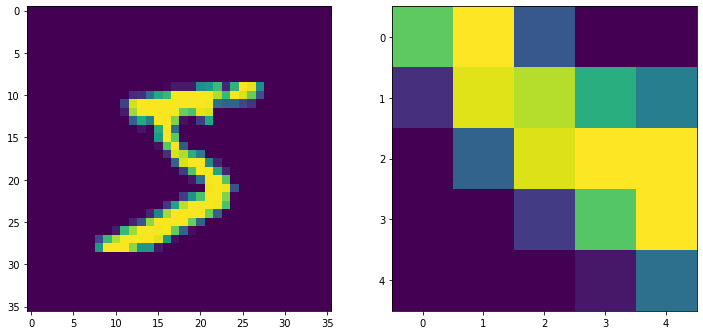

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(train_images_padded[0])
axs[1].imshow(patch_test[12, 12])

## Neuron model

In [6]:
rng = np.random.default_rng()

class LIFEnsemble:
    
    def __init__(self, input_size, filter_count):
        self.filter_count = filter_count

        self.exc_weights = rng.uniform(size=(filter_count, input_size))
        self.inh_weights = np.zeros((filter_count, filter_count))
        self.thresholds = np.full(filter_count, fill_value=5.0)

        self.reset()
        
        self.alpha = 0.01
        self.beta = 0.0001
        self.rho = 0.05
        self.gamma = 0.02
    
    def reset(self):
        self.membrane_potential = np.zeros(self.filter_count)
        self.input_current = np.zeros(self.filter_count)
        self.spikes = [np.zeros(self.filter_count)]
        
    def step(self, pixels):
        self.input_current = self.exc_weights @ pixels - self.inh_weights @ self.spikes[-1]
        self.membrane_potential += self.input_current
        
        self.spikes.append(self.membrane_potential > self.thresholds)
        self.membrane_potential *= ~self.spikes[-1]
        
    def update(self, pixels):
        n_i = np.stack(self.spikes[1:]).sum(0)
        
        self.inh_weights += self.alpha * (np.outer(n_i, n_i) - self.rho**2)
        self.inh_weights[np.diag_indices_from(self.inh_weights)] = 0
        # self.inh_weights = np.minimum(self.inh_weights, 0)

        self.exc_weights += self.beta * np.outer(n_i, pixels - n_i @ self.exc_weights)
        # self.exc_weights = np.maximum(self.exc_weights, 0)

        self.thresholds += self.gamma * (n_i - self.rho)
        
        self.reset()
        
    def present(self, pixels, step_count):
        # initialize neurons
        membrane_potential = np.zeros(self.filter_count)
        spikes = np.zeros((step_count + 1, self.filter_count), dtype=np.bool)
        
        # input_current = self.exc_weights @ pixels - self.inh_weights @ self.spikes[-1]
        # the first part is the same each loop, so we precompute it for performance
        exc_potential = self.exc_weights @ pixels
        for step in range(step_count):
            membrane_potential += exc_potential
            membrane_potential -= self.inh_weights @ self.spikes[-1]
            
            spikes[step] = membrane_potential >= self.thresholds
            membrane_potential *= ~spikes[-1]

        # apply learning rules
        n_i = spikes.sum(axis=0)
        
        self.inh_weights += self.alpha * (np.outer(n_i, n_i) - self.rho**2)
        self.inh_weights[np.diag_indices_from(self.inh_weights)] = 0

        self.exc_weights += self.beta * np.outer(n_i, pixels - n_i @ self.exc_weights)

        self.thresholds += self.gamma * (n_i - self.rho)
        

In [7]:
def plot_activations(ensemble, sample_image):    
    fig, axs = plt.subplots(2, 3, figsize=(10, 6))
    for i, axs in enumerate(axs.flatten()):
        axs.imshow(ensemble.exc_weights[i].reshape(5, 5))
    plt.show()
    
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))
    for filter_idx in range(16):
        image_activations = np.zeros((28, 28))
        image_padded = np.pad(sample_image, 4)
        for i in range(28):
            for j in range(28):
                activation = (ensemble.exc_weights[filter_idx].reshape(5, 5) @ image_padded[i:i + 5, j:j + 5]).sum()
                image_activations[i, j] = activation

        axs[filter_idx // 4][filter_idx % 4].imshow(image_activations)

    fig.suptitle('Filter activations')
    plt.show()

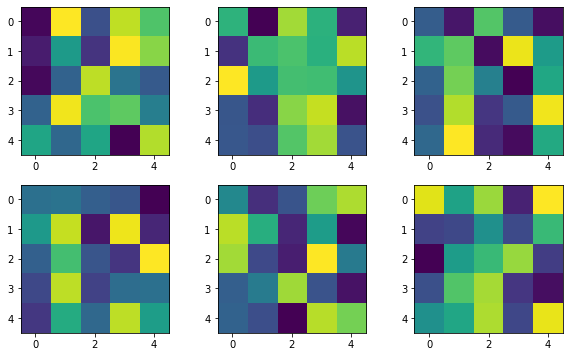

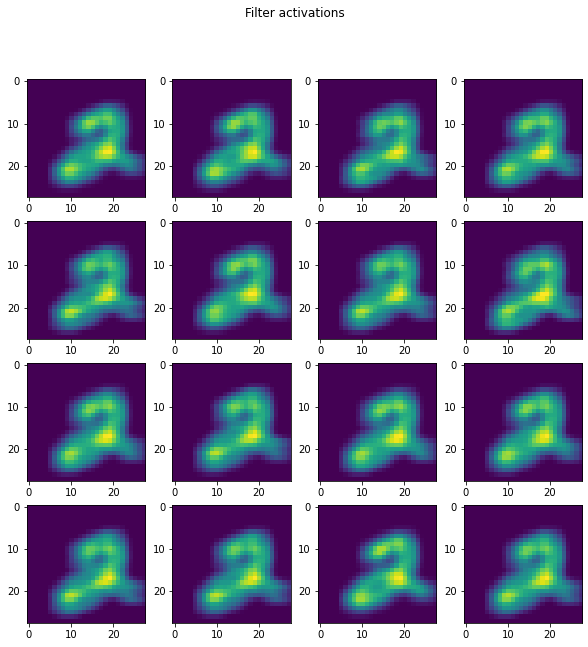

In [8]:
ensemble = LIFEnsemble(25, 16)
plot_activations(ensemble, train_images[5])

In [9]:
ensemble = LIFEnsemble(25, 16)
for image in tqdm(train_images[:100]):
    patches = conv2d_patches(image)
    for patch in patches.reshape(576, 25):
        for time_step in range(20):
            ensemble.step(patch)

        ensemble.update(patch)

  0%|          | 0/100 [00:00<?, ?it/s]

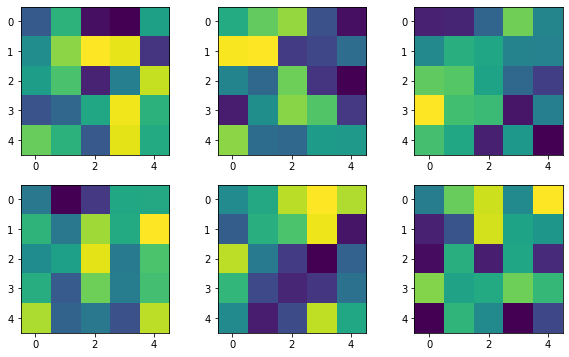

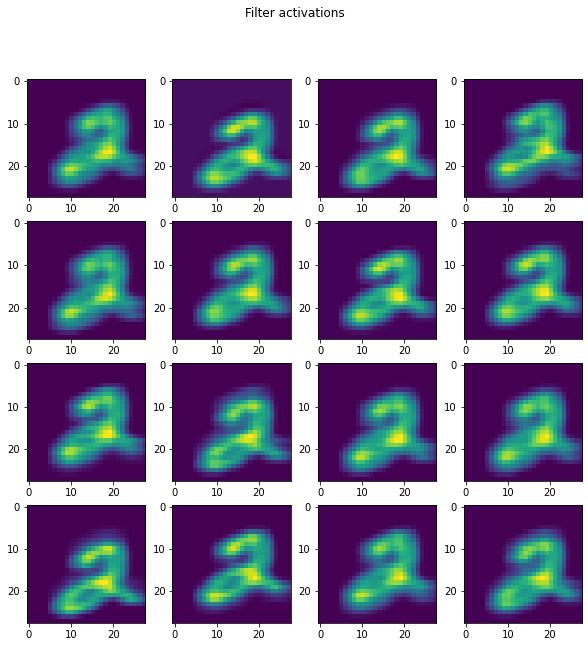

In [10]:
plot_activations(ensemble, train_images[5])

In [11]:
ensemble = LIFEnsemble(25, 16)
for image in tqdm(train_images[:1000]):
    patches = conv2d_patches(image)
    for patch in patches.reshape(576, 25):
        ensemble.present(patch, 20)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
plot_activations(ensemble, train_images[5])

In [ ]:
class IFEnsemble:    
    
    def __init__(self, input_values):
        self.input = input_values
        
        self.reset()
        
    def reset(self):
        self.membrane_potential = np.zeros(self.filter_count)
        self.spike = np.zeros(self.filter_count)        

    def step(self):
        self.membrane_potential += self.input
        self.spikes = self.membrane_potential >= 1
        self.membrane_potential -= self.input * self.spikes
        
        return self.spikes

In [ ]:
class ConvLayer:
    
    def __init__(self, exc_weights, in_ensemble):
        self.exc_weights = exc_weights
        self.filter_size = len(in_ensemble.input)
        self.num_filters = exc_weights.shape[0]
        
        self.reset()       

    def reset(self):        
        self.membrane_potential = np.zeros((self.filter_size, self.num_filters))
        self.input_current = np.zeros((self.filter_size, self.num_filters))
        self.spikes = [np.zeros(self.filter_count)]
        
    def step(self, pixels):
        pixels_ensemble = IFEnsemble(pixels)
        
        for t in range(20):
            pixel_spikes = pixels_ensemble.step()
        
            patches = conv2d_patches(pixels, padding=4).reshape(-1, 5, 5)
            for i, patch_i in enumerate(patches):
                self.input_current[i] = kernel @ pixel_spikes
                self.membrane_potential[i] += self.input_current[i]